**Initialization**

The notebook has been tested using GPU T4 x2

In [1]:
import os
import random
from matplotlib import pyplot as plt
import cv2

import numpy as np
import pandas as pd

from keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout
from keras.metrics import Precision, Recall

import keras_tuner as kt
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

2024-02-18 11:50:31.619842: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 11:50:31.619941: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 11:50:31.932788: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Listing input train and test data**

In [16]:
top_dir = '/kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset'

# Define the training paths
train_dir = os.path.join(top_dir, 'train')

# List all directories in the train directory
all_directories = os.listdir(train_dir)

# Initialize lists to store directories for human-drawn and AI-generated images
train_human = []
train_ai = []

# Loop through all directories
for directory in all_directories:
    # Check if the directory represents human-drawn images
    if not directory.startswith('AI_'):
        train_human.append(os.path.join(train_dir, directory))
    # Check if the directory represents AI-generated images
    else:
        train_ai.append(os.path.join(train_dir, directory))

# Print the lists of directories
print("Train directories containing human-drawn images:")
for i, directory in enumerate(train_human):
    print(f"{i}. {directory}")

print("\nTrain directories containing AI-generated images:")
for i, directory in enumerate(train_ai):
    print(f"{i}. {directory}")


Train directories containing human-drawn images:
0. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/impressionism
1. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/renaissance
2. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/surrealism
3. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/art_nouveau
4. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/baroque
5. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/expressionism
6. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/romanticism
7. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/ukiyo_e
8. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/post_impressionism
9. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/realism

Train directories containing AI-generated images:
0. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/AI_SD_impressionism
1. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/AI_LD_post_impressionism
2. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/tr

In [17]:
# Define the test paths
test_dir = os.path.join(top_dir, 'test')

# List all directories in the test directory
all_directories = os.listdir(test_dir)

# Initialize lists to store directories for human-drawn and AI-generated images
test_human = []
test_ai = []

# Loop through all directories
for directory in all_directories:
    # Check if the directory represents human-drawn images
    if not directory.startswith('AI_'):
        test_human.append(os.path.join(test_dir, directory))
    # Check if the directory represents AI-generated images
    else:
        test_ai.append(os.path.join(test_dir, directory))

# Print the lists of directories
print("Test directories containing human-drawn images:")
for i, directory in enumerate(test_human):
    print(f"{i}. {directory}")

print("\nTest directories containing AI-generated images:")
for i, directory in enumerate(test_ai):
    print(f"{i}. {directory}")

Test directories containing human-drawn images:
0. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/impressionism
1. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/renaissance
2. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/surrealism
3. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/art_nouveau
4. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/baroque
5. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/expressionism
6. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/romanticism
7. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/ukiyo_e
8. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/post_impressionism
9. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/realism

Test directories containing AI-generated images:
0. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/AI_SD_impressionism
1. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/AI_LD_post_impressionism
2. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/AI_LD_art_n

**Dataset analysis**

In [18]:
# Plot k-number of images from the dataset
def plot_im(directory, k):
    files = os.listdir(directory)
    im = random.choices(files, k=k)

    fig = plt.figure()

    for i in range(k):
        im_i_path = os.path.join(directory, im[i])  # File path
        im_i = cv2.imread(im_i_path)
        
        # Add subplot
        ax = fig.add_subplot(int(np.sqrt(k)), int(np.sqrt(k)), i + 1)
        
        # Plot image
        ax.imshow(im_i)
        ax.axis('off')
        
        # Display filename below the image
        ax.set_title(im[i], fontsize=8, pad=2)

    plt.tight_layout()  # Adjust layout
    plt.show()

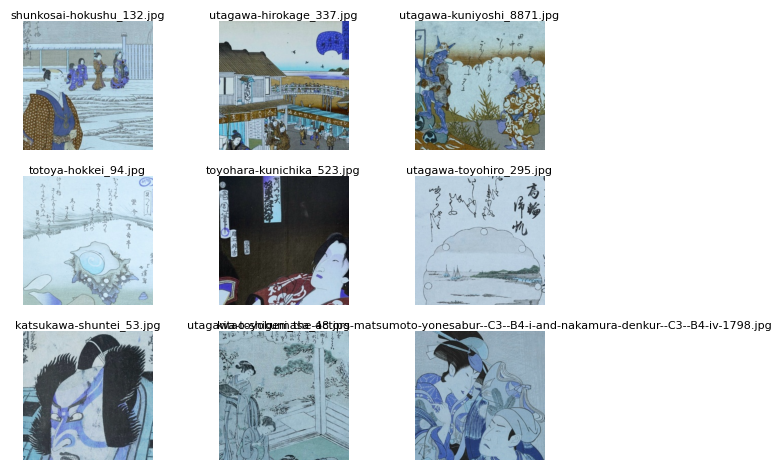

In [19]:
# Visualize random images from train_human. Catagory is sorted in order of output in cell 2
real_im = plot_im(directory=train_human[7], k=9)  
plt.show()

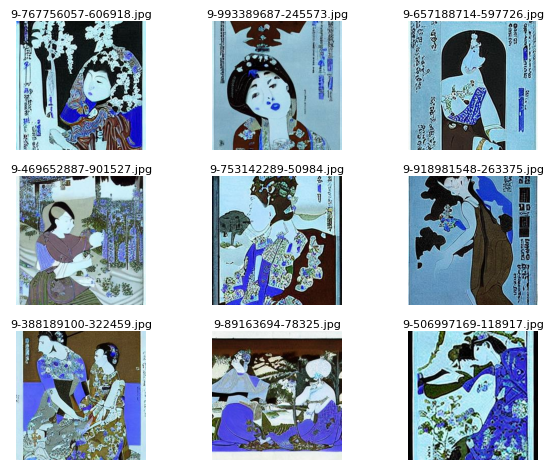

In [20]:
# Visualize random images from train_ai. Catagory is sorted in order of output in cell 2
ai_im = plot_im(directory=train_ai[4], k=9)  
plt.show()

**Setting up train and test set under labels "human" and "AI"**

**Labelling the training set**

In [23]:
# Initialize lists to store file paths and labels
filepaths = []
labels = []

# Initialize an empty DataFrame for train_data
train_data = pd.DataFrame(columns=['filepath', 'label'])

# Label files under train_human as "human"
for directory in train_human:
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append("human")

# Label files under train_ai as "AI"
for directory in train_ai:
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append("AI")

# Create a DataFrame with file paths and labels
data = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Concatenate data with train_data
train_data = pd.concat([train_data, data], ignore_index=True)

In [24]:
# Display the first few rows of the train_data DataFrame
print(train_data.head())

                                            filepath  label
0  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
1  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
2  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
3  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
4  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human


In [25]:
# Count the number of files under each label
file_counts = train_data['label'].value_counts()

# Print the counts
print("Number of files under each label:")
print(file_counts)

Number of files under each label:
label
AI       105015
human     50000
Name: count, dtype: int64


**Reducing AI data to balance-off**

In [26]:
# Set the random seed for reproducibility
random_seed = 123  # Change this to your desired seed number
np.random.seed(random_seed)

# Number of rows to drop for the 'AI' label
num_to_drop = 55015

# Get the indices of rows with the 'AI' label
ai_indices = train_data[train_data['label'] == 'AI'].index

# Randomly select indices to drop using the specified seed
indices_to_drop = np.random.choice(ai_indices, num_to_drop, replace=False)

# Drop the selected rows from the DataFrame
train_data = train_data.drop(indices_to_drop)

# Reset the index of the DataFrame after dropping rows
train_data.reset_index(drop=True, inplace=True)

In [27]:
# Display the first few rows of the train_data DataFrame
print(train_data.head())

# Count the number of files under each label
file_counts = train_data['label'].value_counts()

# Print the counts
print("\nNumber of files under each label:")
print(file_counts)

                                            filepath  label
0  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
1  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
2  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
3  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
4  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human

Number of files under each label:
label
human    50000
AI       50000
Name: count, dtype: int64


**Labelling the test set**

In [28]:
# Initialize lists to store file paths and labels
filepaths = []
labels = []

# Initialize an empty DataFrame for test_data
test_data = pd.DataFrame(columns=['filepath', 'label'])

# Label files under test_human as "human"
for directory in test_human:
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append("human")

# Label files under test_ai as "AI"
for directory in test_ai:
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append("AI")

# Create a DataFrame with file paths and labels
data = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Concatenate data with test_data
test_data = pd.concat([test_data, data], ignore_index=True)

In [29]:
# Display the first few rows of the test_data DataFrame
print(test_data.head())

# Count the number of files under each label
file_counts = test_data['label'].value_counts()

# Print the counts
print("\nNumber of files under each label:")
print(file_counts)

                                            filepath  label
0  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
1  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
2  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
3  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
4  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human

Number of files under each label:
label
AI       20000
human    10000
Name: count, dtype: int64


**Creating the train set**

In [30]:
training_generator = ImageDataGenerator(rescale=1./255,   # to normalize pixel value
                                       # rotation_range=7, # it will apply rotations to the image
                                       # horizontal_flip=True, # it will flip image horizontally
                                       # zoom_range=0.2  # it will increase and decrease zoom by 0.2x
                                       )
train_dataset = training_generator.flow_from_dataframe(
    dataframe=train_data,
    x_col='filepath',  # Column containing file paths
    y_col='label',     # Column containing labels
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical',  
    shuffle=True
)

Found 100000 validated image filenames belonging to 2 classes.


In [31]:
train_dataset.class_indices

{'AI': 0, 'human': 1}

**Creating the test set**

In [32]:
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_dataframe(  dataframe=test_data,
                                                    x_col='filepath',  # Column containing file paths
                                                    y_col='label',     # Column containing labels
                                                    target_size = (128, 128),
                                                    batch_size = 1,    # 1 image at a time to evaluate the NN
                                                    class_mode = 'categorical',
                                                    shuffle = False)   # to associate the prediction with expected output

test_dataset.class_indices

Found 30000 validated image filenames belonging to 2 classes.


{'AI': 0, 'human': 1}

**Building the neural network**

In [33]:
network = Sequential()
network.add(Conv2D(filters = 64, kernel_size = 3, input_shape = (128,128,3), activation='relu'))
network.add(MaxPooling2D())
network.add(Conv2D(filters = 64, kernel_size = 3, activation='relu'))
network.add(MaxPooling2D())
network.add(Flatten())
network.add(Dense(units = 64, activation='relu'))
network.add(Dense(units = 2, activation='softmax'))


In [34]:
network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 64)                3

In [35]:
from keras.callbacks import ModelCheckpoint

# Define the file path where the model will be saved
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Compile the model
network.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

**Training the neural network**

In [36]:
import time

# Initial epoch count
epochs = 10

# Initialize total training time
total_training_time = 0

# Loop to allow user to continue training
while True:
    # Record start time
    start_time = time.time()
    
    # Fit the model for the specified number of epochs
    history = network.fit_generator(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint])
    
    # Calculate training time for the current batch of epochs
    training_time = time.time() - start_time
    total_training_time += training_time
    
    # Print total training time
    print("Total training time so far: {:.2f} seconds".format(total_training_time))
    
    # Prompt the user to continue training or stop
    user_input = input("Enter 'c' to continue training for more epochs, or any other key to stop: ")
    
    # If user input is not 'c', break out of the loop
    if user_input != 'c':
        break
    
    # Ask the user for the number of additional epochs
    additional_epochs = int(input("Enter the number of additional epochs you want to train for: "))
    
    # Update the epoch count for the next training loop
    epochs = additional_epochs

/tmp/ipykernel_34/1392878394.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = network.fit_generator(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint])


Epoch 1/10


I0000 00:00:1708258123.992362     121 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1563/1563 [==============================] - ETA: 0s - loss: 0.3126 - accuracy: 0.8600
Epoch 1: val_accuracy improved from -inf to 0.89130, saving model to best_model.h5
1563/1563 [==============================] - 1415s 901ms/step - loss: 0.3126 - accuracy: 0.8600 - val_loss: 0.2510 - val_accuracy: 0.8913
Epoch 2/10


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1563/1563 [==============================] - ETA: 0s - loss: 0.1838 - accuracy: 0.9246
Epoch 2: val_accuracy improved from 0.89130 to 0.93453, saving model to best_model.h5
1563/1563 [==============================] - 539s 345ms/step - loss: 0.1838 - accuracy: 0.9246 - val_loss: 0.1647 - val_accuracy: 0.9345
Epoch 3/10
1563/1563 [==============================] - ETA: 0s - loss: 0.1311 - accuracy: 0.9487
Epoch 3: val_accuracy did not improve from 0.93453
1563/1563 [==============================] - 531s 340ms/step - loss: 0.1311 - accuracy: 0.9487 - val_loss: 0.1642 - val_accuracy: 0.9333
Epoch 4/10
1563/1563 [==============================] - ETA: 0s - loss: 0.0938 - accuracy: 0.9642
Epoch 4: val_accuracy improved from 0.93453 to 0.94830, saving model to best_model.h5
1563/1563 [==============================] - 529s 338ms/step - loss: 0.0938 - accuracy: 0.9642 - val_loss: 0.1375 - val_accuracy: 0.9483
Epoch 5/10
1563/1563 [==============================] - ETA: 0s - loss: 0.0631 - ac

Enter 'c' to continue training for more epochs, or any other key to stop:  f


**Evaluating the network**

In [37]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

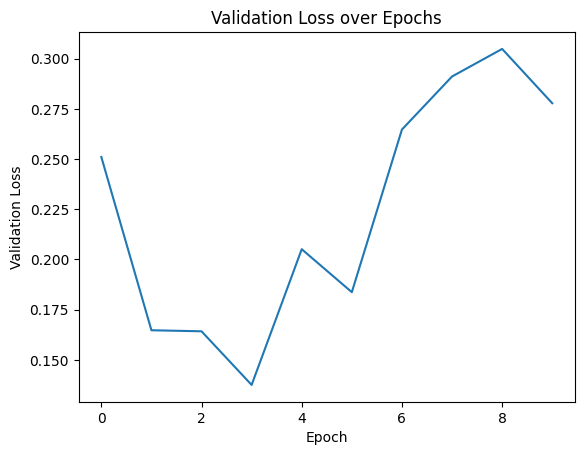

In [38]:
plt.plot(history.history['val_loss']);
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss over Epochs')
plt.show()

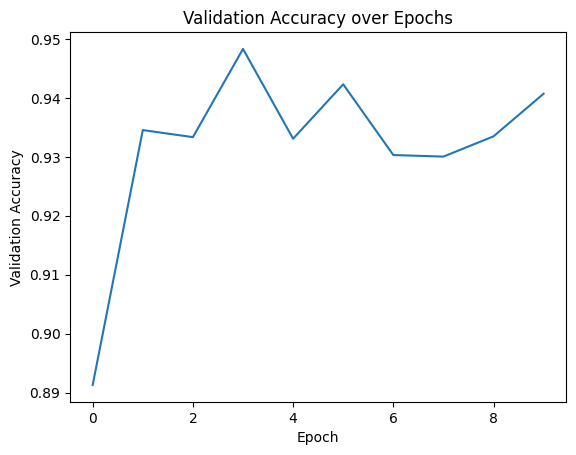

In [39]:
plt.plot(history.history['val_accuracy']);
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.show()

In [40]:
predictions = network.predict(test_dataset)
predictions

30000/30000 [==============================] - 127s 4ms/step


array([[1.8943757e-07, 9.9999976e-01],
       [1.2970357e-01, 8.7029642e-01],
       [3.9200262e-07, 9.9999964e-01],
       ...,
       [9.9999785e-01, 2.1414901e-06],
       [9.5837712e-01, 4.1622832e-02],
       [9.9982709e-01, 1.7297089e-04]], dtype=float32)

In [41]:
test_dataset.class_indices

{'AI': 0, 'human': 1}

In [42]:
predictions = np.argmax(predictions, axis = 1)
predictions

array([1, 1, 1, ..., 0, 0, 0])

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     20000
           1       0.92      0.90      0.91     10000

    accuracy                           0.94     30000
   macro avg       0.93      0.93      0.93     30000
weighted avg       0.94      0.94      0.94     30000



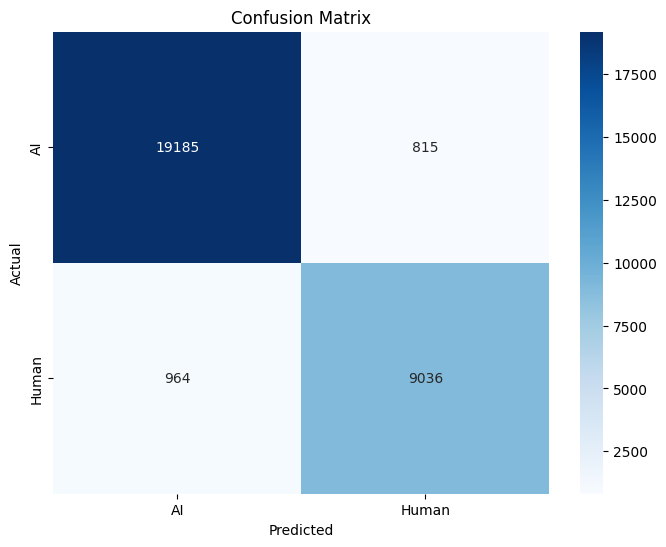

In [43]:
#import seaborn as sns 
#from sklearn.metrics import confusion_matrix, classification_report
#cm = confusion_matrix(test_dataset.classes, predictions)
#sns.heatmap(cm, annot=True)
#print(classification_report(test_dataset.classes, predictions))

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Calculate confusion matrix and classification report
cm = confusion_matrix(test_dataset.classes, predictions)
report = classification_report(test_dataset.classes, predictions)

# Define custom labels for the axes
labels = ['AI', 'Human']
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')

# Add labels to the axes
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Print classification report
print(report)

# Show the plot
plt.show()


**Optional: Saving the model network and weights seperately**

In [44]:
model_json = network.to_json()
with open('network.json','w') as json_file:
  json_file.write(model_json) #save network json

from keras.models import save_model
network_saved = save_model(network, '/kaggle/working/weights.hdf5') 

/tmp/ipykernel_34/695762010.py:6: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  network_saved = save_model(network, '/kaggle/working/weights.hdf5')
